# Model2
## Choose the best number of features for model2

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# load the data
file_path = '../../matrix/otu_merged_data.csv' 
df = pd.read_csv(file_path)


def map_concentration(value):
    if pd.isna(value):
        return "unknown"  
    elif value == 0:
        return "none"
    elif value in [5, 10]:
        return "low"
    elif value in [50, 100]:
        return "high"
    else:
        return "unknown"  

antibiotics = ['amoxicillin', 'oxytetracycline_dihydrate', 'sulfadiazine', 'trimethoprim', 'tylosin_tartrate', 'ciprofloxacin']
for antibiotic in antibiotics:
    df[antibiotic] = df[antibiotic].apply(map_concentration)

df['antibiotic_combination'] = df[antibiotics].apply(lambda row: '_'.join(row), axis=1)
df_cleaned = df.dropna()


feature_columns = [col for col in df_cleaned.columns if col.startswith('o__')]
X = df_cleaned[feature_columns]
X = pd.concat([X, df_cleaned[['Isolation_source', 'Group']]], axis=1)
X = pd.get_dummies(X, columns=['Isolation_source', 'Group'])

y = df_cleaned['antibiotic_combination']
y_encoded = y.astype('category').cat.codes


models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42)
}


accuracy_scores = {}
for k in range(10, 101, 10):
    print(f"Using top {k} features")

    # select the top k features
    selector = SelectKBest(chi2, k=k)
    X_selected = selector.fit_transform(X, y_encoded)


    X_train, X_test, y_train, y_test = train_test_split(X_selected, y_encoded, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    best_accuracy = 0
    for name, model in models.items():
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        acc = accuracy_score(y_test, y_pred)
        print(f"Model: {name}, Accuracy: {acc:.4f}")
        if acc > best_accuracy:
            best_accuracy = acc

    accuracy_scores[k] = best_accuracy


Using top 10 features
Model: Random Forest, Accuracy: 0.3413
Model: SVM, Accuracy: 0.1587
Model: Decision Tree, Accuracy: 0.2381
Model: Logistic Regression, Accuracy: 0.2460
Using top 20 features
Model: Random Forest, Accuracy: 0.3730
Model: SVM, Accuracy: 0.2857
Model: Decision Tree, Accuracy: 0.2857
Model: Logistic Regression, Accuracy: 0.3413
Using top 30 features
Model: Random Forest, Accuracy: 0.3810
Model: SVM, Accuracy: 0.3571
Model: Decision Tree, Accuracy: 0.2937
Model: Logistic Regression, Accuracy: 0.4603
Using top 40 features
Model: Random Forest, Accuracy: 0.4365
Model: SVM, Accuracy: 0.3571
Model: Decision Tree, Accuracy: 0.2698
Model: Logistic Regression, Accuracy: 0.4683
Using top 50 features
Model: Random Forest, Accuracy: 0.3730
Model: SVM, Accuracy: 0.3333
Model: Decision Tree, Accuracy: 0.2143
Model: Logistic Regression, Accuracy: 0.4603
Using top 60 features
Model: Random Forest, Accuracy: 0.4286
Model: SVM, Accuracy: 0.3095
Model: Decision Tree, Accuracy: 0.3175
M

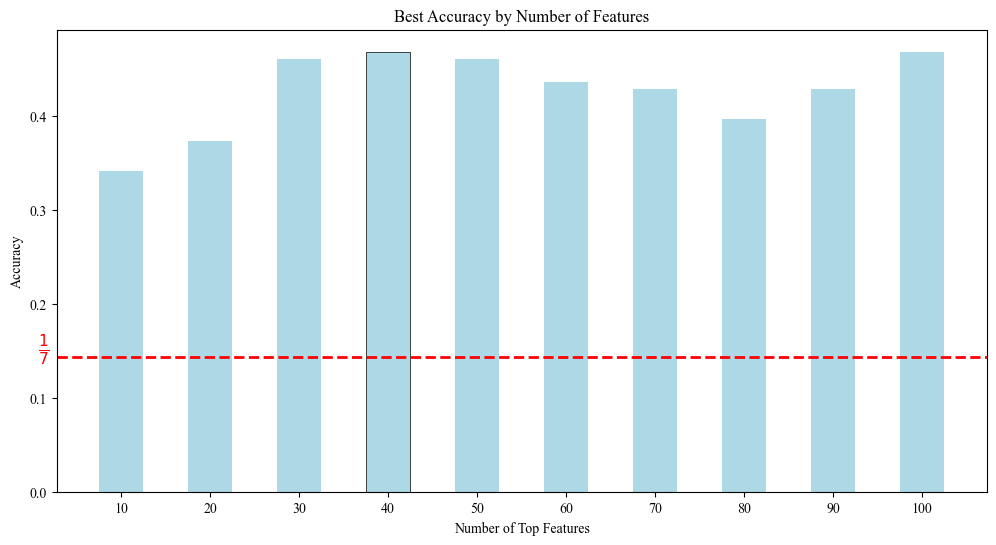

In [4]:
import matplotlib as mpl

mpl.rcParams['font.family'] = 'Times New Roman'
plt.figure(figsize=(12, 6))
# plt.bar(accuracy_scores.keys(), accuracy_scores.values(), color='lightblue',width=5)
max_value = max(accuracy_scores.values())
max_key = [k for k, v in accuracy_scores.items() if v == max_value][0]

for key, value in accuracy_scores.items():
    if key == max_key:
        plt.bar(key, value, color='lightblue', width=5, edgecolor='black', linewidth=0.5) 
    else:
        plt.bar(key, value, color='lightblue', width=5)


plt.axhline(y=1/7, color='red', linestyle='dashed', linewidth=2)
plt.text(2, 1/7-0.01, r'$\frac{1}{7}$', verticalalignment='bottom', horizontalalignment='right', color='red', fontsize=16)
plt.title('Best Accuracy by Number of Features')
plt.xlabel('Number of Top Features')
plt.ylabel('Accuracy')
plt.xticks(range(10, 101, 10))
# plt.show()
plt.savefig('feature_selection.pdf', dpi=300)

   

In [3]:
best_k = max(accuracy_scores, key=accuracy_scores.get)
best_k

40

## Draw the confusion matrix for the given input

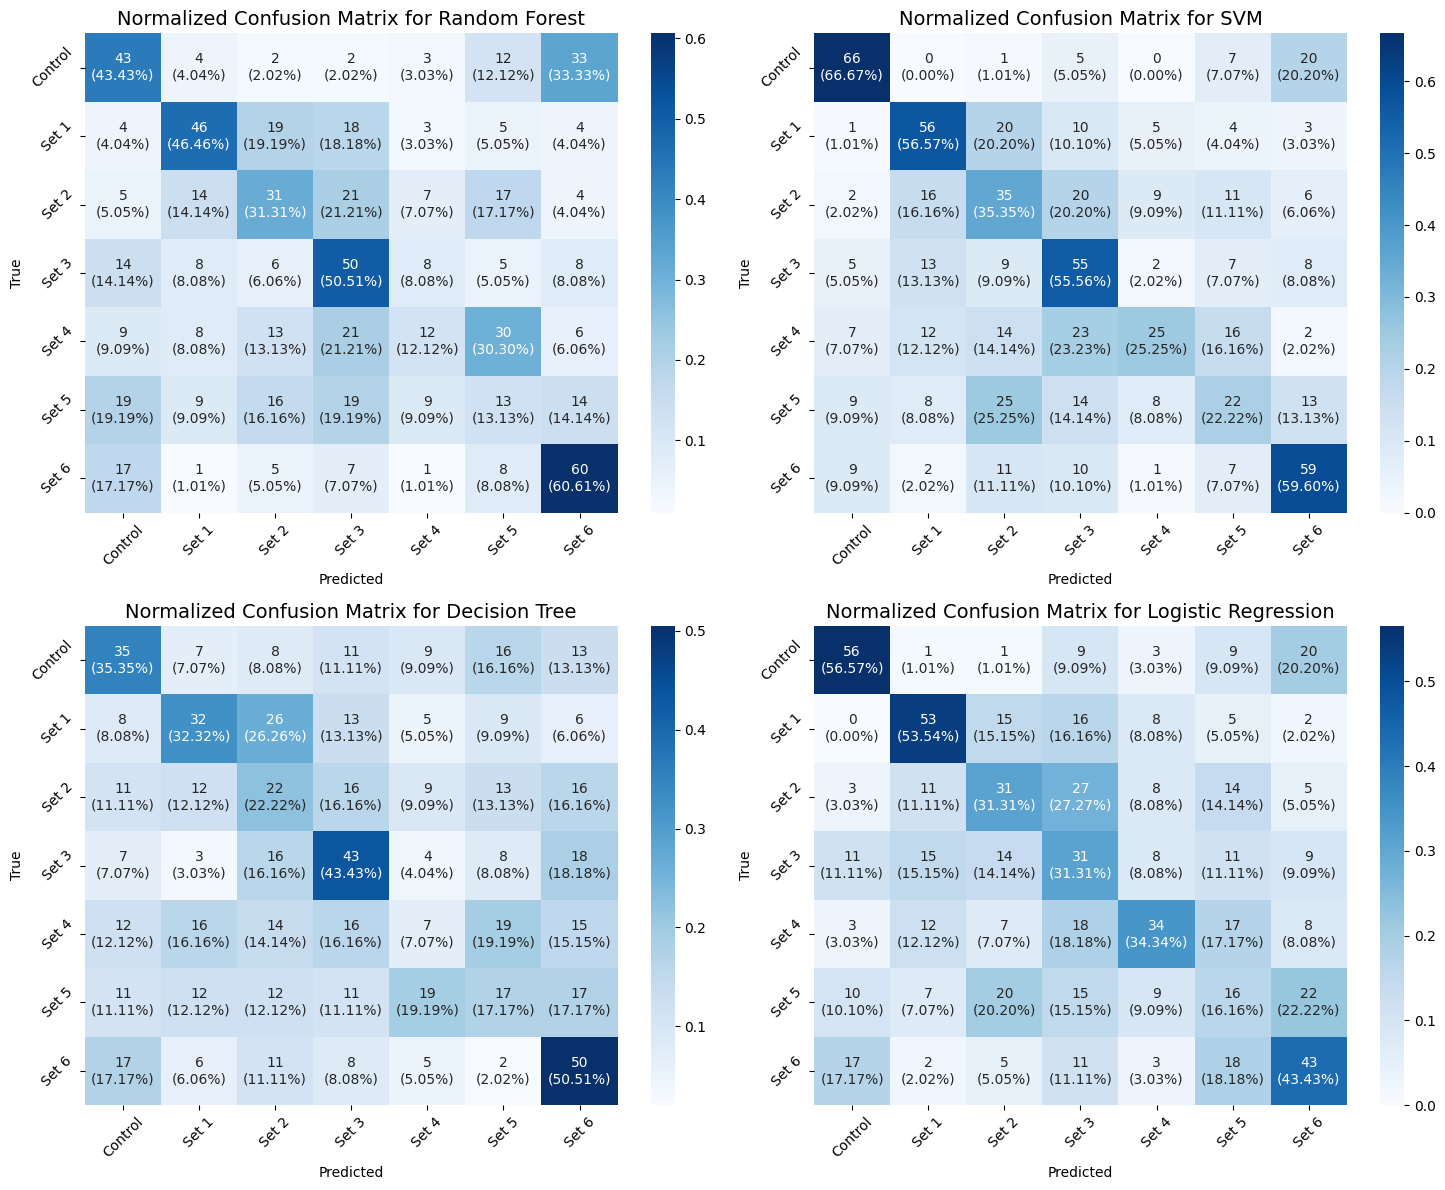

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import RandomOverSampler
import warnings

warnings.filterwarnings('ignore')


df = pd.read_csv('../../matrix/otu_merged_data.csv')

def map_concentration(value):
    if pd.isna(value):
        return "unknown"
    elif value == 0:
        return "none"
    elif value in [5, 10]:
        return "low"
    elif value in [50, 100]:
        return "high"
    else:
        return "unknown"

antibiotics = ['amoxicillin', 'oxytetracycline_dihydrate', 'sulfadiazine', 'trimethoprim', 'tylosin_tartrate', 'ciprofloxacin']
for antibiotic in antibiotics:
    df[antibiotic] = df[antibiotic].apply(map_concentration)

def map_to_set(row):
    if all(value == 'unknown' for value in row):
        return 'Unknown'
    mapping = {
        'high_high_high_high_high_high': 'Set 1',
        'high_high_high_none_none_none': 'Set 2',
        'high_none_none_none_none_none': 'Set 3',
        'low_low_low_low_low_low': 'Set 4',
        'low_low_low_none_none_none': 'Set 5',
        'low_none_none_none_none_none': 'Set 6',
        'none_none_none_none_none_none': 'Control'
    }
    key = '_'.join(row)
    return mapping.get(key, 'Other')

df['set_name'] = df[antibiotics].apply(map_to_set, axis=1)

df_cleaned = df.dropna()

feature_columns = [col for col in df_cleaned.columns if col.startswith('o__')]
X = df_cleaned[feature_columns]
X = pd.concat([X, df_cleaned[['Isolation_source', 'Group']]], axis=1)
X = pd.get_dummies(X, columns=['Isolation_source', 'Group'])

y = df_cleaned['set_name']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

best_k = best_k # get from previous example
selector = SelectKBest(chi2, k=best_k)
X_selected = selector.fit_transform(X, y_encoded)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

ros = RandomOverSampler()
X_resampled, y_resampled = ros.fit_resample(X_scaled, y_encoded)
X_balanced, y_balanced = X_resampled, y_resampled

models = {
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(probability=True),
    "Decision Tree": DecisionTreeClassifier(),
    "Logistic Regression": LogisticRegression()
}

param_grids = {
    "Random Forest": {'n_estimators': [100, 200], 'max_depth': [10, 20]},
    "SVM": {'C': [1, 10], 'kernel': ['rbf', 'linear']},
    "Decision Tree": {'max_depth': [5, 10]},
    "Logistic Regression": {'C': [1, 10]}
}

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))
axes = axes.flatten() 

for ax, (name, model) in zip(axes, models.items()):
    grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='roc_auc_ovr')
    grid_search.fit(X_balanced, y_balanced)
    best_model = grid_search.best_estimator_
    
    y_pred = cross_val_predict(best_model, X_balanced, y_balanced, cv=5)
    y_balanced_labels = label_encoder.inverse_transform(y_balanced)
    y_pred_labels = label_encoder.inverse_transform(y_pred)
    cm = confusion_matrix(y_balanced_labels, y_pred_labels, labels=label_encoder.classes_)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    annot_array = np.vectorize(lambda x, y: f'{x}\n({y:.2%})')(cm, cm_normalized)
    
    sns.heatmap(cm_normalized, annot=annot_array, fmt="", cmap='Blues', ax=ax)
    ax.set_title(f'Normalized Confusion Matrix for {name}', fontsize=14)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_xticklabels(labels=label_encoder.classes_, rotation=45)
    ax.set_yticklabels(labels=label_encoder.classes_, rotation=45)

plt.tight_layout()
# plt.savefig('confusion_matrices.pdf', format='pdf', dpi=300)


## Draw the ROC plot on the test set

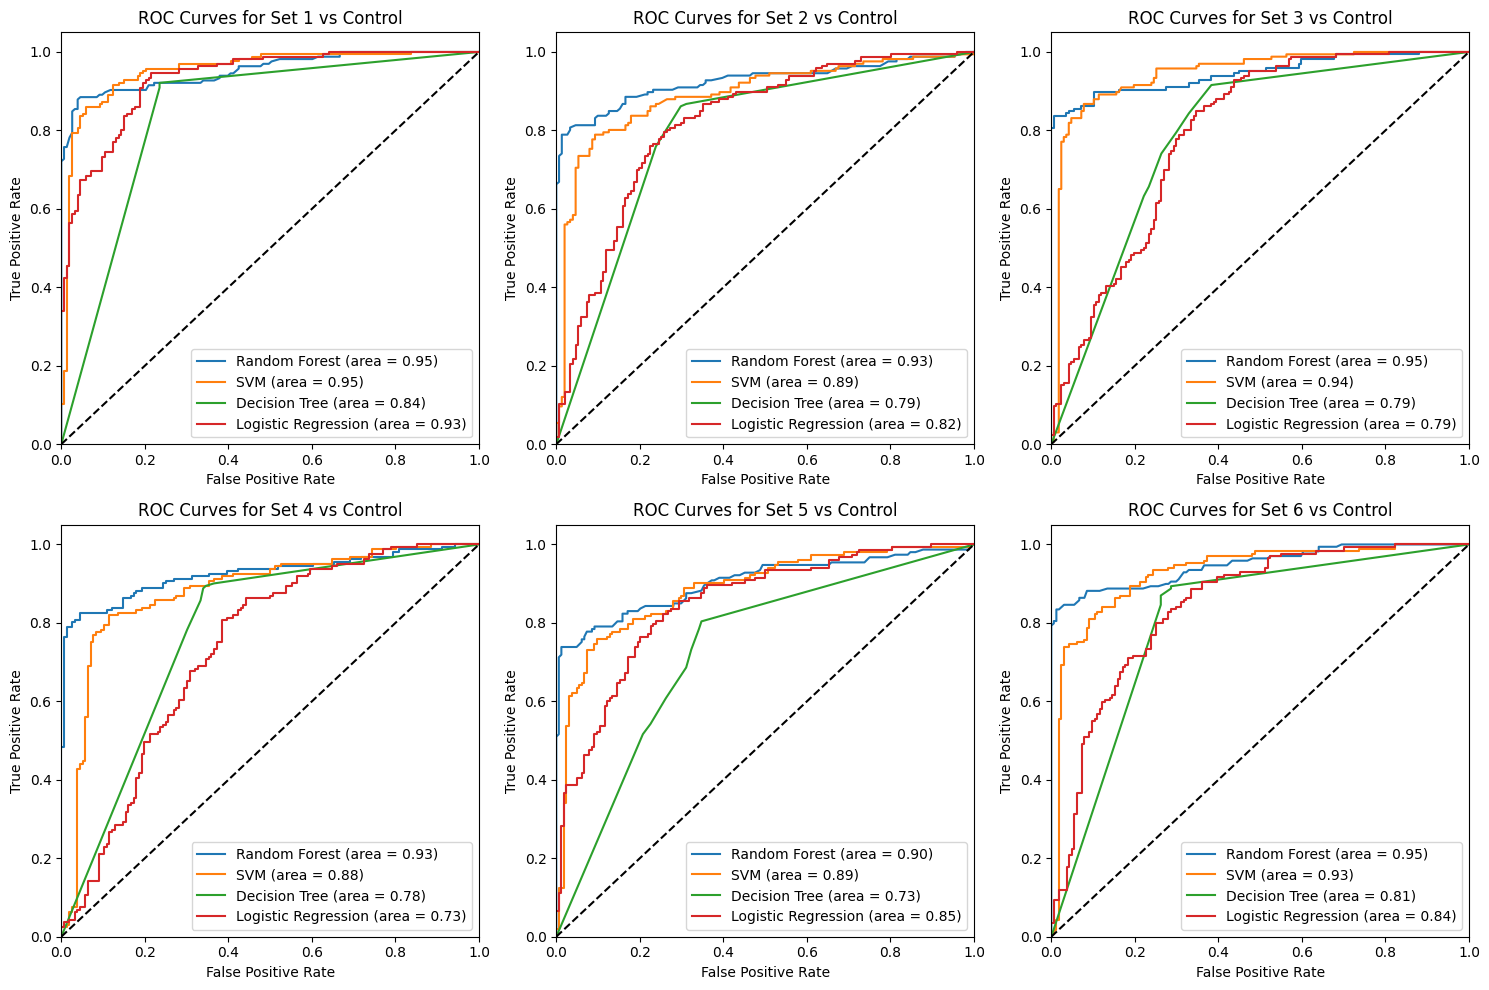

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2
import numpy as np
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import warnings

warnings.filterwarnings('ignore')

best_k=40
df = pd.read_csv('../../matrix/otu_merged_data.csv') 

def map_concentration(value):
    if pd.isna(value):
        return "unknown"
    elif value == 0:
        return "none"
    elif value in [5, 10]:
        return "low"
    elif value in [50, 100]:
        return "high"
    else:
        return "unknown"

antibiotics = ['amoxicillin', 'oxytetracycline_dihydrate', 'sulfadiazine', 'trimethoprim', 'tylosin_tartrate', 'ciprofloxacin']
for antibiotic in antibiotics:
    df[antibiotic] = df[antibiotic].apply(map_concentration)

def map_to_set(row):
    mapping = {
        'high_high_high_high_high_high': 'Set 1',
        'high_high_high_none_none_none': 'Set 2',
        'high_none_none_none_none_none': 'Set 3',
        'low_low_low_low_low_low': 'Set 4',
        'low_low_low_none_none_none': 'Set 5',
        'low_none_none_none_none_none': 'Set 6',
        'none_none_none_none_none_none': 'Control'
    }
    key = '_'.join(row)
    return mapping.get(key, 'Other')

df['set_name'] = df[antibiotics].apply(map_to_set, axis=1)

df_cleaned = df.dropna()


feature_columns = [col for col in df_cleaned.columns if col.startswith('o__')]
X = df_cleaned[feature_columns]
X = pd.concat([X, df_cleaned[['Isolation_source', 'Group']]], axis=1)
X = pd.get_dummies(X, columns=['Isolation_source', 'Group'])

scaler = StandardScaler()

models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(random_state=42, probability=True),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42)
}

param_grids = {
    "Random Forest": {'n_estimators': [100, 200], 'max_depth': [10, 20]},
    "SVM": {'C': [1, 10], 'kernel': ['rbf', 'linear']},
    "Decision Tree": {'max_depth': [5, 10]},
    "Logistic Regression": {'C': [1, 10]}
}


sets = ['Set 1', 'Set 2', 'Set 3', 'Set 4', 'Set 5', 'Set 6', 'Control']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.ravel() 

for i, set_name in enumerate(['Set 1', 'Set 2', 'Set 3', 'Set 4', 'Set 5', 'Set 6']):
    ax = axes[i]


    y_binary = df_cleaned['set_name'].apply(lambda x: 1 if x == set_name else 0)

    selector = SelectKBest(chi2, k=best_k)
    X_selected = selector.fit_transform(X, y_binary)
    X_scaled = scaler.fit_transform(X_selected)


    ros = RandomOverSampler(random_state=42)
    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = ros.fit_resample(X_scaled, y_binary)
    # X_balanced, y_balanced = rus.fit_resample(X_resampled, y_resampled)
    X_balanced, y_balanced = X_resampled, y_resampled
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3)
    
    
    for name, model in models.items():
        grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='roc_auc')
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        y_probas = cross_val_predict(best_model, X_test, y_test, cv=5, method='predict_proba')
        fpr, tpr, _ = roc_curve(y_test, y_probas[:, 1])
        roc_auc = auc(fpr, tpr)

        ax.plot(fpr, tpr, label=f'{name} (area = {roc_auc:.2f})')

    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curves for {set_name} vs Control')
    ax.legend(loc="lower right")

plt.tight_layout()
plt.show()


In [2]:
import matplotlib
import seaborn as sns

In [1]:
from sklearn.metrics import roc_curve, auc
import numpy as np
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

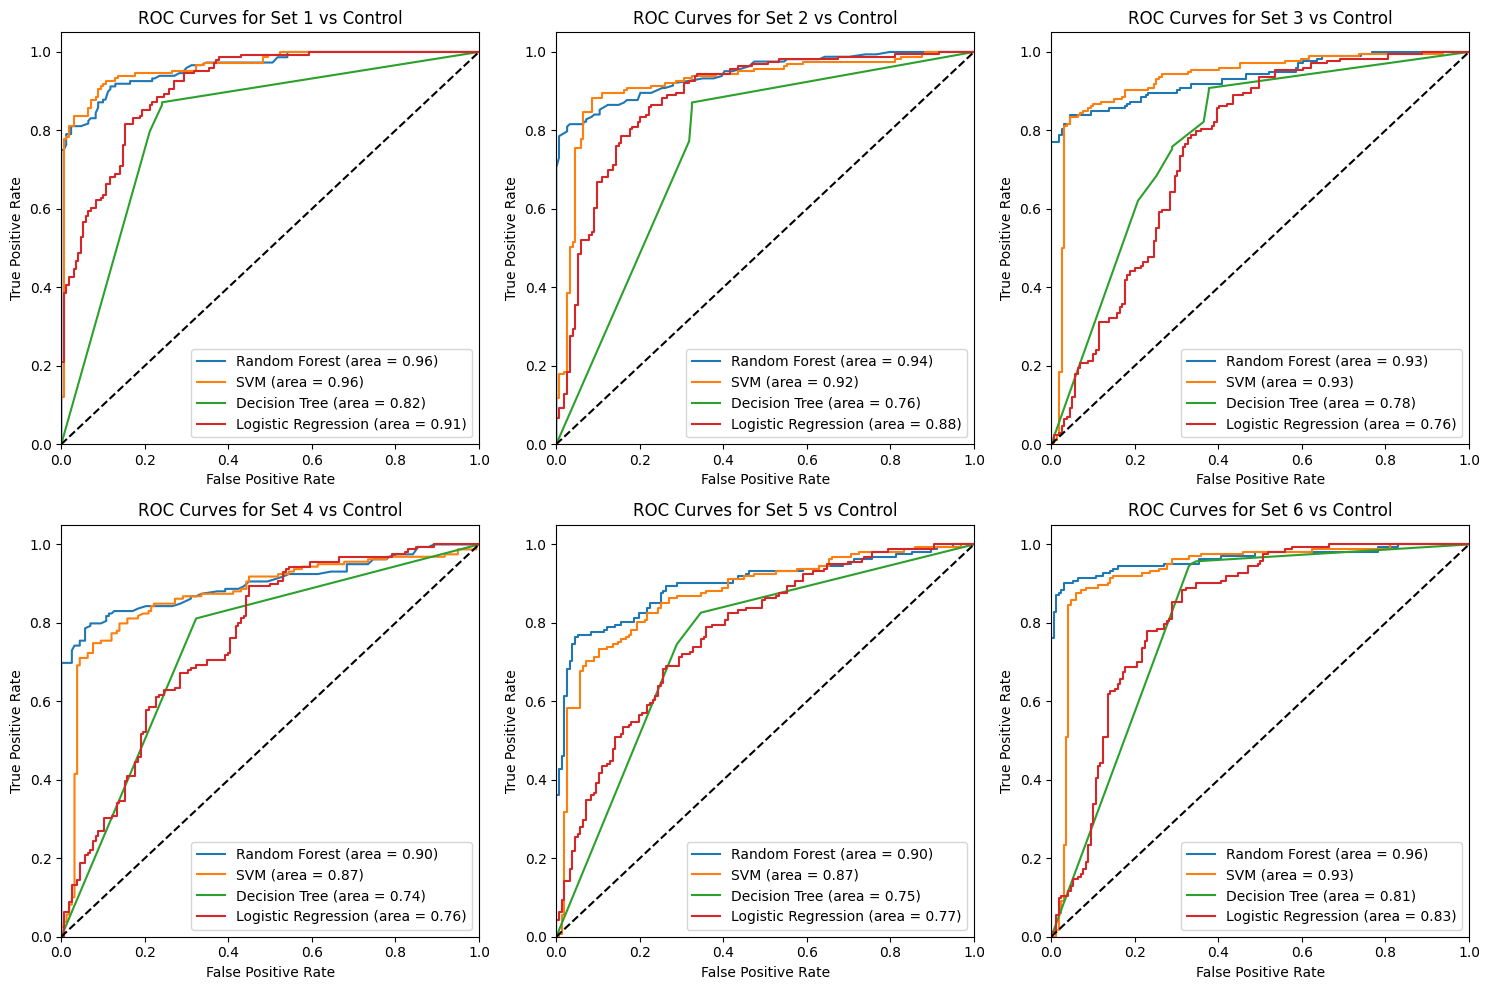

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2
import numpy as np
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import warnings

warnings.filterwarnings('ignore')

best_k=40
df = pd.read_csv('../../matrix/otu_merged_data.csv') 

def map_concentration(value):
    if pd.isna(value):
        return "unknown"
    elif value == 0:
        return "none"
    elif value in [5, 10]:
        return "low"
    elif value in [50, 100]:
        return "high"
    else:
        return "unknown"

antibiotics = ['amoxicillin', 'oxytetracycline_dihydrate', 'sulfadiazine', 'trimethoprim', 'tylosin_tartrate', 'ciprofloxacin']
for antibiotic in antibiotics:
    df[antibiotic] = df[antibiotic].apply(map_concentration)

def map_to_set(row):
    mapping = {
        'high_high_high_high_high_high': 'Set 1',
        'high_high_high_none_none_none': 'Set 2',
        'high_none_none_none_none_none': 'Set 3',
        'low_low_low_low_low_low': 'Set 4',
        'low_low_low_none_none_none': 'Set 5',
        'low_none_none_none_none_none': 'Set 6',
        'none_none_none_none_none_none': 'Control'
    }
    key = '_'.join(row)
    return mapping.get(key, 'Other')

df['set_name'] = df[antibiotics].apply(map_to_set, axis=1)

df_cleaned = df.dropna()


feature_columns = [col for col in df_cleaned.columns if col.startswith('o__')]
X = df_cleaned[feature_columns]
X = pd.concat([X, df_cleaned[['Isolation_source', 'Group']]], axis=1)
X = pd.get_dummies(X, columns=['Isolation_source', 'Group'])

scaler = StandardScaler()

models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(random_state=42, probability=True),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42)
}

param_grids = {
    "Random Forest": {'n_estimators': [100, 200], 'max_depth': [10, 20]},
    "SVM": {'C': [1, 10], 'kernel': ['rbf', 'linear']},
    "Decision Tree": {'max_depth': [5, 10]},
    "Logistic Regression": {'C': [1, 10]}
}


sets = ['Set 1', 'Set 2', 'Set 3', 'Set 4', 'Set 5', 'Set 6', 'Control']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.ravel() 

for i, set_name in enumerate(['Set 1', 'Set 2', 'Set 3', 'Set 4', 'Set 5', 'Set 6']):
    ax = axes[i]


    y_binary = df_cleaned['set_name'].apply(lambda x: 1 if x == set_name else 0)

    selector = SelectKBest(chi2, k=best_k)
    X_selected = selector.fit_transform(X, y_binary)
    X_scaled = scaler.fit_transform(X_selected)


    ros = RandomOverSampler(random_state=42)
    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = ros.fit_resample(X_scaled, y_binary)
    # X_balanced, y_balanced = rus.fit_resample(X_resampled, y_resampled)
    X_balanced, y_balanced = X_resampled, y_resampled
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3)
    
    
    for name, model in models.items():
        grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='roc_auc')
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        y_probas = cross_val_predict(best_model, X_test, y_test, cv=5, method='predict_proba')
        fpr, tpr, _ = roc_curve(y_test, y_probas[:, 1])
        roc_auc = auc(fpr, tpr)

        ax.plot(fpr, tpr, label=f'{name} (area = {roc_auc:.2f})')

    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curves for {set_name} vs Control')
    ax.legend(loc="lower right")

plt.tight_layout()
plt.show()


In [1]:
import matplotlib as mpl

mpl.rcParams['font.family'] = 'Times New Roman'

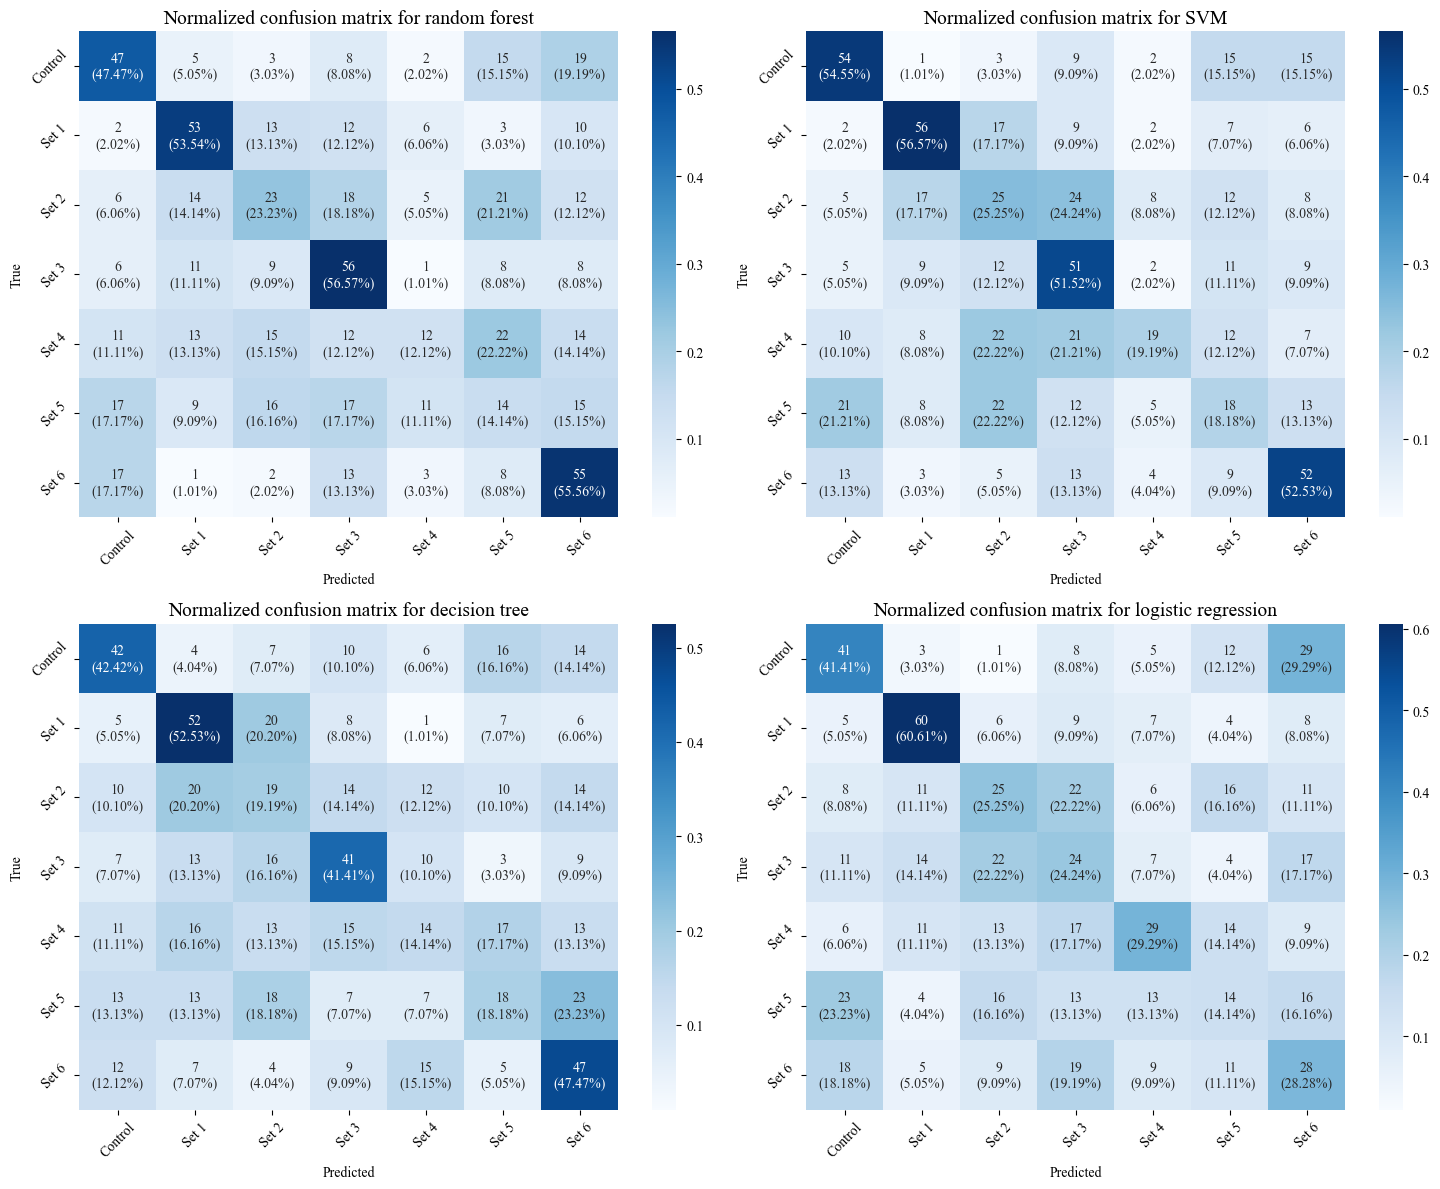

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import RandomOverSampler
import warnings

import matplotlib as mpl
import matplotlib.gridspec as gridspec

# 设置字体为Times New Roman
mpl.rcParams['font.family'] = 'Times New Roman'

warnings.filterwarnings('ignore')


df = pd.read_csv('../../matrix/otu_merged_data.csv')

def map_concentration(value):
    if pd.isna(value):
        return "unknown"
    elif value == 0:
        return "none"
    elif value in [5, 10]:
        return "low"
    elif value in [50, 100]:
        return "high"
    else:
        return "unknown"

antibiotics = ['amoxicillin', 'oxytetracycline_dihydrate', 'sulfadiazine', 'trimethoprim', 'tylosin_tartrate', 'ciprofloxacin']
for antibiotic in antibiotics:
    df[antibiotic] = df[antibiotic].apply(map_concentration)

def map_to_set(row):
    if all(value == 'unknown' for value in row):
        return 'Unknown'
    mapping = {
        'high_high_high_high_high_high': 'Set 1',
        'high_high_high_none_none_none': 'Set 2',
        'high_none_none_none_none_none': 'Set 3',
        'low_low_low_low_low_low': 'Set 4',
        'low_low_low_none_none_none': 'Set 5',
        'low_none_none_none_none_none': 'Set 6',
        'none_none_none_none_none_none': 'Control'
    }
    key = '_'.join(row)
    return mapping.get(key, 'Other')

df['set_name'] = df[antibiotics].apply(map_to_set, axis=1)

df_cleaned = df.dropna()

feature_columns = [col for col in df_cleaned.columns if col.startswith('o__')]
X = df_cleaned[feature_columns]
X = pd.concat([X, df_cleaned[['Isolation_source', 'Group']]], axis=1)
X = pd.get_dummies(X, columns=['Isolation_source', 'Group'])

y = df_cleaned['set_name']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

best_k = 20 # get from previous example
selector = SelectKBest(chi2, k=best_k)
X_selected = selector.fit_transform(X, y_encoded)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

ros = RandomOverSampler()
X_resampled, y_resampled = ros.fit_resample(X_scaled, y_encoded)
X_balanced, y_balanced = X_resampled, y_resampled

models = {
    "random forest": RandomForestClassifier(),
    "SVM": SVC(probability=True),
    "decision tree": DecisionTreeClassifier(),
    "logistic regression": LogisticRegression()
}

param_grids = {
    "random forest": {'n_estimators': [100, 200], 'max_depth': [10, 20]},
    "SVM": {'C': [1, 10], 'kernel': ['rbf', 'linear']},
    "decision tree": {'max_depth': [5, 10]},
    "logistic regression": {'C': [1, 10]}
}

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))
axes = axes.flatten() 

for ax, (name, model) in zip(axes, models.items()):
    grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='roc_auc_ovr')
    grid_search.fit(X_balanced, y_balanced)
    best_model = grid_search.best_estimator_
    
    y_pred = cross_val_predict(best_model, X_balanced, y_balanced, cv=5)
    y_balanced_labels = label_encoder.inverse_transform(y_balanced)
    y_pred_labels = label_encoder.inverse_transform(y_pred)
    cm = confusion_matrix(y_balanced_labels, y_pred_labels, labels=label_encoder.classes_)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    annot_array = np.vectorize(lambda x, y: f'{x}\n({y:.2%})')(cm, cm_normalized)
    
    sns.heatmap(cm_normalized, annot=annot_array, fmt="", cmap='Blues', ax=ax)
    ax.set_title(f'Normalized confusion matrix for {name}', fontsize=14)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_xticklabels(labels=label_encoder.classes_, rotation=45)
    ax.set_yticklabels(labels=label_encoder.classes_, rotation=45)

plt.tight_layout()
plt.savefig('confusion_matrices.pdf', format='pdf', dpi=300)
# plt.show()


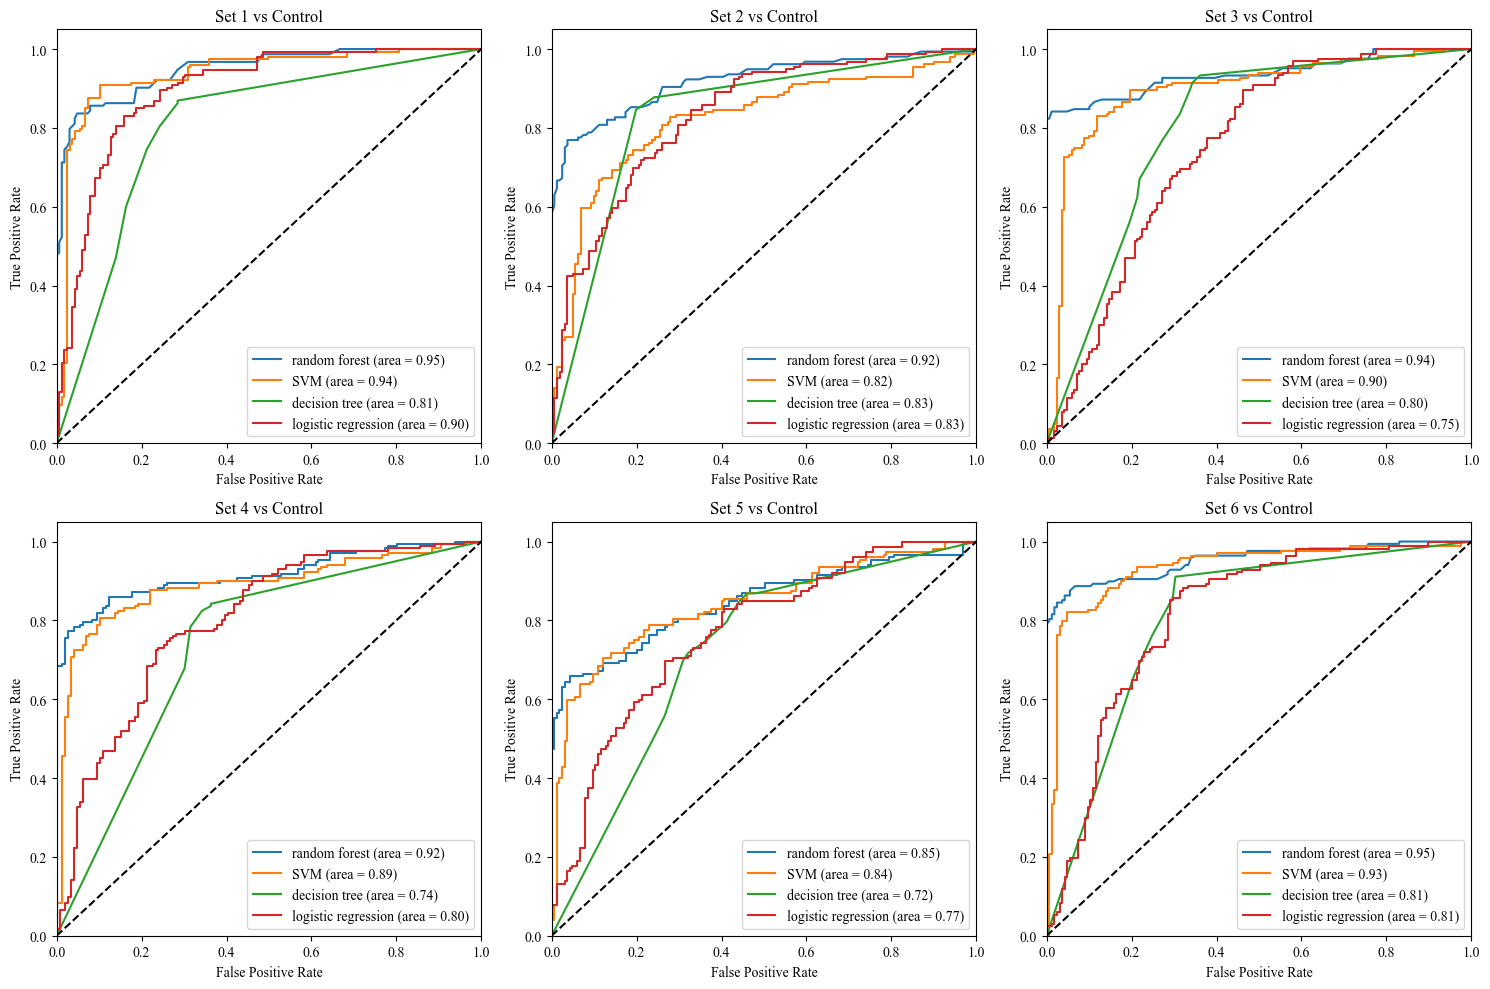

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2
import numpy as np
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import warnings
import matplotlib as mpl

mpl.rcParams['font.family'] = 'Times New Roman'
warnings.filterwarnings('ignore')

best_k=40
df = pd.read_csv('../../matrix/otu_merged_data.csv') 

def map_concentration(value):
    if pd.isna(value):
        return "unknown"
    elif value == 0:
        return "none"
    elif value in [5, 10]:
        return "low"
    elif value in [50, 100]:
        return "high"
    else:
        return "unknown"

antibiotics = ['amoxicillin', 'oxytetracycline_dihydrate', 'sulfadiazine', 'trimethoprim', 'tylosin_tartrate', 'ciprofloxacin']
for antibiotic in antibiotics:
    df[antibiotic] = df[antibiotic].apply(map_concentration)

def map_to_set(row):
    mapping = {
        'high_high_high_high_high_high': 'Set 1',
        'high_high_high_none_none_none': 'Set 2',
        'high_none_none_none_none_none': 'Set 3',
        'low_low_low_low_low_low': 'Set 4',
        'low_low_low_none_none_none': 'Set 5',
        'low_none_none_none_none_none': 'Set 6',
        'none_none_none_none_none_none': 'Control'
    }
    key = '_'.join(row)
    return mapping.get(key, 'Other')

df['set_name'] = df[antibiotics].apply(map_to_set, axis=1)

df_cleaned = df.dropna()


feature_columns = [col for col in df_cleaned.columns if col.startswith('o__')]
X = df_cleaned[feature_columns]
X = pd.concat([X, df_cleaned[['Isolation_source', 'Group']]], axis=1)
X = pd.get_dummies(X, columns=['Isolation_source', 'Group'])

scaler = StandardScaler()

models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(random_state=42, probability=True),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42)
}

param_grids = {
    "Random Forest": {'n_estimators': [100, 200], 'max_depth': [10, 20]},
    "SVM": {'C': [1, 10], 'kernel': ['rbf', 'linear']},
    "Decision Tree": {'max_depth': [5, 10]},
    "Logistic Regression": {'C': [1, 10]}
}


sets = ['Set 1', 'Set 2', 'Set 3', 'Set 4', 'Set 5', 'Set 6', 'Control']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.ravel() 

for i, set_name in enumerate(['Set 1', 'Set 2', 'Set 3', 'Set 4', 'Set 5', 'Set 6']):
    ax = axes[i]


    y_binary = df_cleaned['set_name'].apply(lambda x: 1 if x == set_name else 0)

    selector = SelectKBest(chi2, k=best_k)
    X_selected = selector.fit_transform(X, y_binary)
    X_scaled = scaler.fit_transform(X_selected)


    ros = RandomOverSampler(random_state=42)
    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = ros.fit_resample(X_scaled, y_binary)
    # X_balanced, y_balanced = rus.fit_resample(X_resampled, y_resampled)
    X_balanced, y_balanced = X_resampled, y_resampled
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3)
    
    
    for name, model in models.items():
        grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='roc_auc')
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        y_probas = cross_val_predict(best_model, X_test, y_test, cv=5, method='predict_proba')
        fpr, tpr, _ = roc_curve(y_test, y_probas[:, 1])
        roc_auc = auc(fpr, tpr)

        ax.plot(fpr, tpr, label=f'{name} (area = {roc_auc:.2f})')

    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'{set_name} vs Control')
    ax.legend(loc="lower right")

plt.tight_layout()
# plt.show()
plt.savefig('roc_curves.pdf', format='pdf', dpi=300)


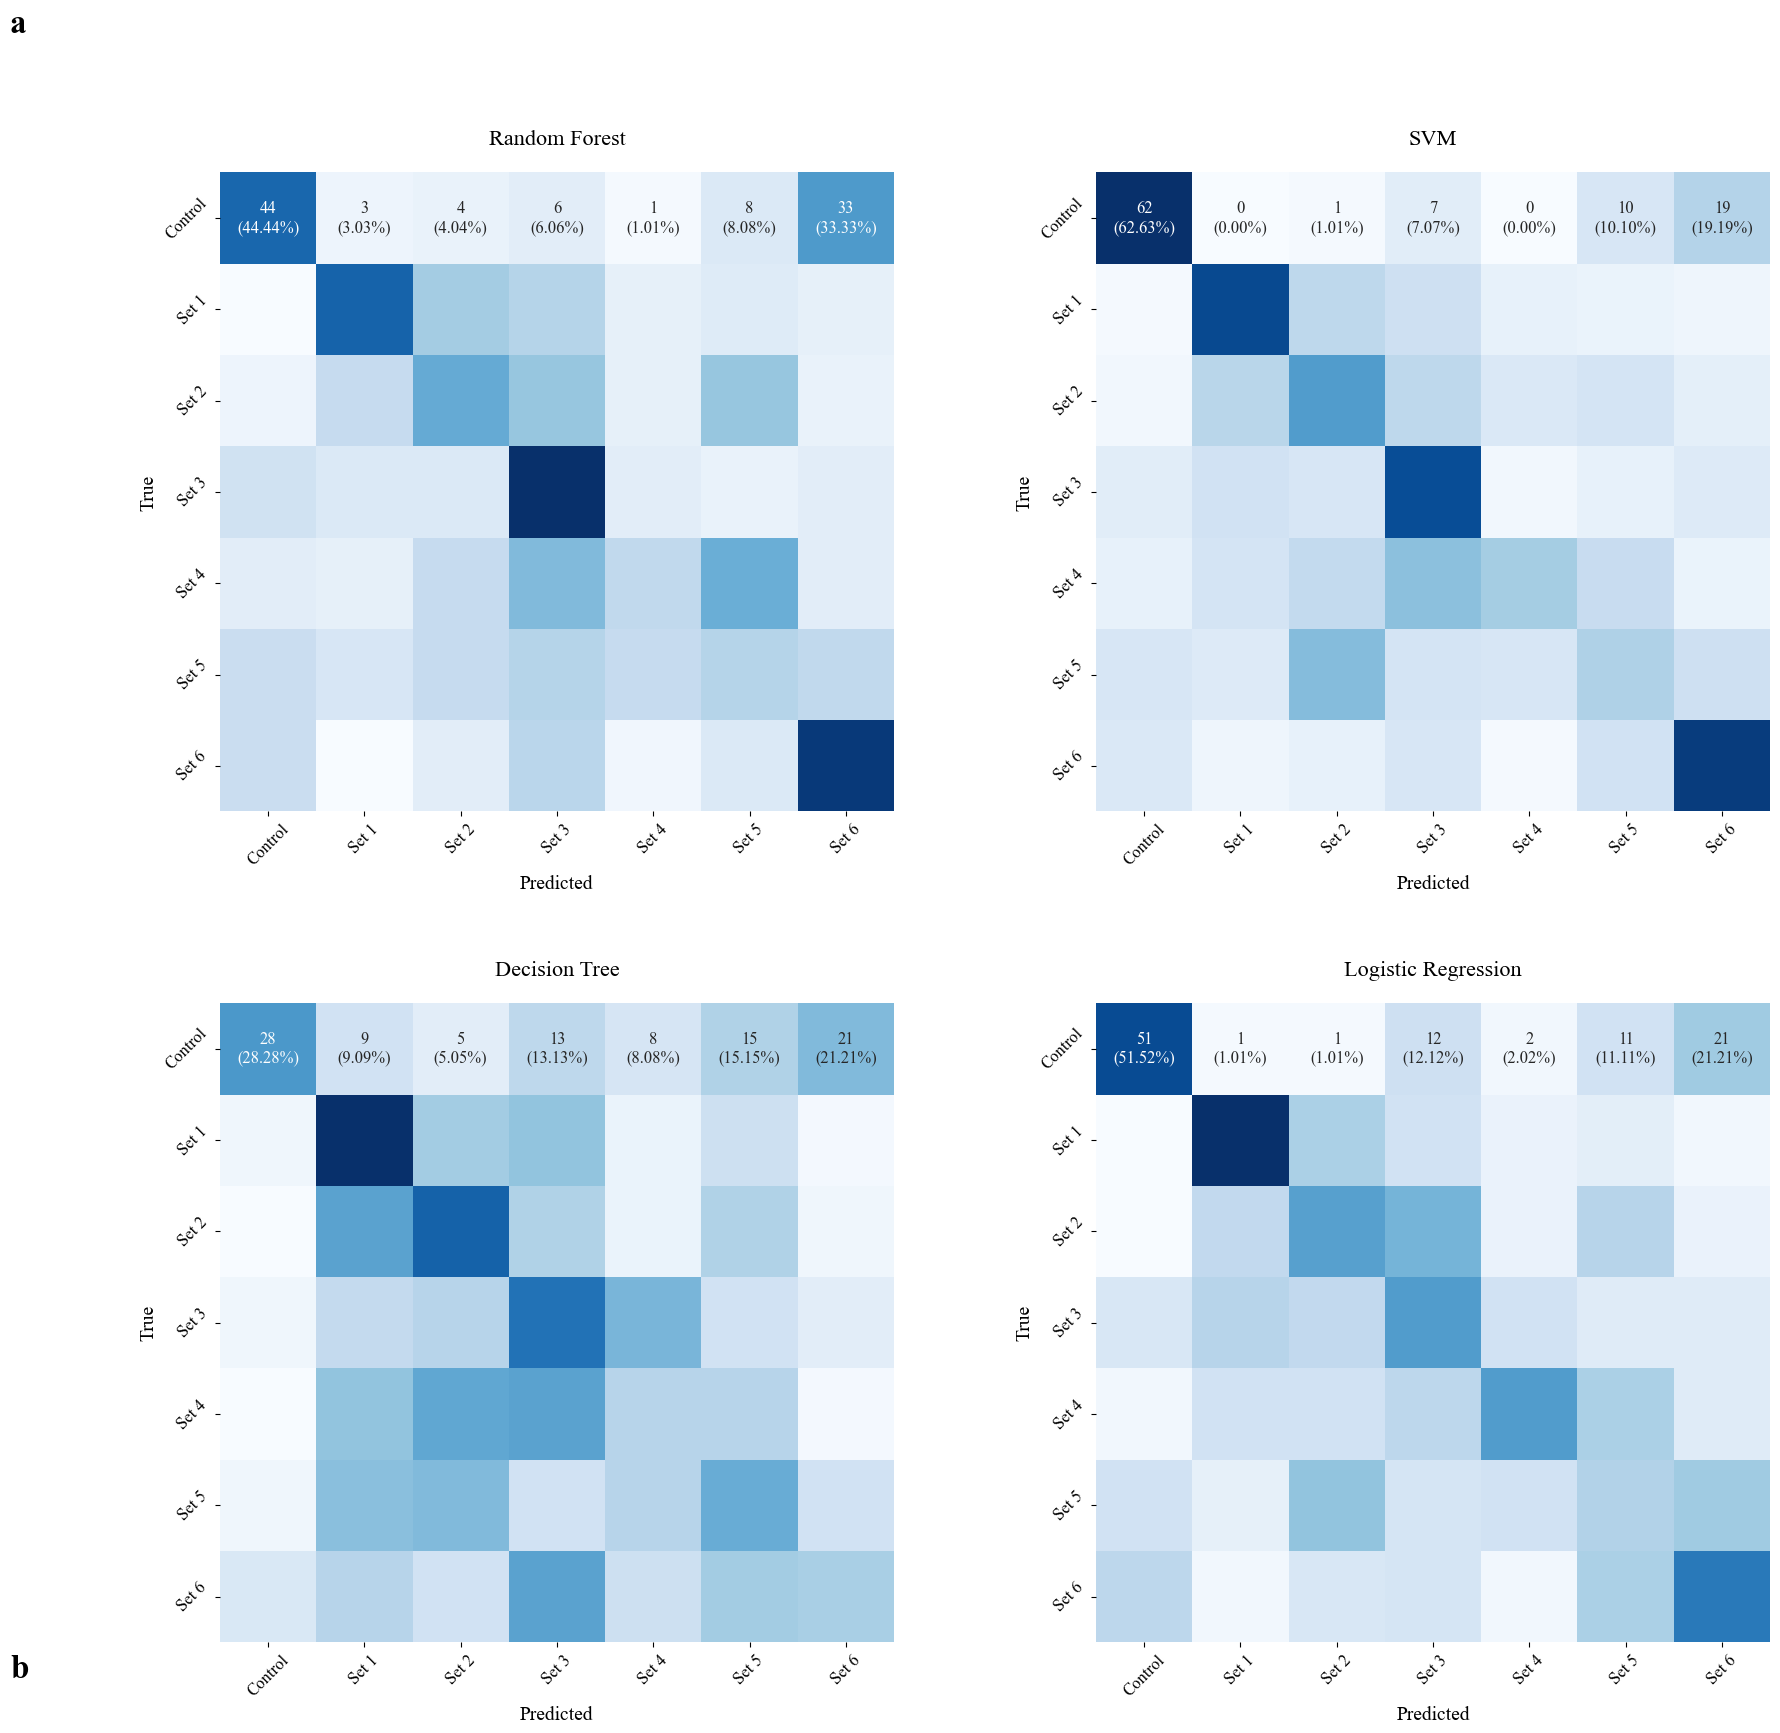

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import GridSearchCV, cross_val_predict, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, roc_curve, auc
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import warnings
import matplotlib as mpl
import matplotlib.gridspec as gridspec

# 设置字体为Times New Roman
mpl.rcParams['font.family'] = 'Times New Roman'

warnings.filterwarnings('ignore')

# 数据加载与预处理
df = pd.read_csv('../../matrix/otu_merged_data.csv')

def map_concentration(value):
    if pd.isna(value):
        return "unknown"
    elif value == 0:
        return "none"
    elif value in [5, 10]:
        return "low"
    elif value in [50, 100]:
        return "high"
    else:
        return "unknown"

antibiotics = ['amoxicillin', 'oxytetracycline_dihydrate', 'sulfadiazine',
              'trimethoprim', 'tylosin_tartrate', 'ciprofloxacin']
for antibiotic in antibiotics:
    df[antibiotic] = df[antibiotic].apply(map_concentration)

def map_to_set(row):
    mapping = {
        'high_high_high_high_high_high': 'Set 1',
        'high_high_high_none_none_none': 'Set 2',
        'high_none_none_none_none_none': 'Set 3',
        'low_low_low_low_low_low': 'Set 4',
        'low_low_low_none_none_none': 'Set 5',
        'low_none_none_none_none_none': 'Set 6',
        'none_none_none_none_none_none': 'Control'
    }
    key = '_'.join(row)
    return mapping.get(key, 'Other')

df['set_name'] = df[antibiotics].apply(map_to_set, axis=1)

df_cleaned = df.dropna()

feature_columns = [col for col in df_cleaned.columns if col.startswith('o__')]
X = df_cleaned[feature_columns]
X = pd.concat([X, df_cleaned[['Isolation_source', 'Group']]], axis=1)
X = pd.get_dummies(X, columns=['Isolation_source', 'Group'])

y = df_cleaned['set_name']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

best_k = 40  # 根据需求设置best_k
selector = SelectKBest(chi2, k=best_k)
X_selected = selector.fit_transform(X, y_encoded)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_scaled, y_encoded)
X_balanced, y_balanced = X_resampled, y_resampled

# 定义模型和参数网格
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(random_state=42, probability=True),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42)
}

param_grids = {
    "Random Forest": {'n_estimators': [100, 200], 'max_depth': [10, 20]},
    "SVM": {'C': [1, 10], 'kernel': ['rbf', 'linear']},
    "Decision Tree": {'max_depth': [5, 10]},
    "Logistic Regression": {'C': [1, 10]}
}

# 创建主图，使用GridSpec分配布局
fig = plt.figure(figsize=(20, 35))
gs = gridspec.GridSpec(2, 1, height_ratios=[1.5, 1], hspace=0.2)

# ------------------- 上部分：混淆矩阵 -------------------
# 创建一个GridSpec用于混淆矩阵的2x2子图
inner_gs1 = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[0], wspace=0.3, hspace=0.3)

confusion_axes = []
for i in range(2):
    for j in range(2):
        ax = plt.Subplot(fig, inner_gs1[i, j])
        confusion_axes.append(ax)
        fig.add_subplot(ax)

for ax, (name, model) in zip(confusion_axes, models.items()):
    grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='roc_auc_ovr')
    grid_search.fit(X_balanced, y_balanced)
    best_model = grid_search.best_estimator_

    y_pred = cross_val_predict(best_model, X_balanced, y_balanced, cv=5)
    y_balanced_labels = label_encoder.inverse_transform(y_balanced)
    y_pred_labels = label_encoder.inverse_transform(y_pred)
    cm = confusion_matrix(y_balanced_labels, y_pred_labels, labels=label_encoder.classes_)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # 创建注释数组，包含样本数量和百分比
    annot_array = np.empty_like(cm).astype(str)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            annot_array[i, j] = f'{cm[i, j]}\n({cm_normalized[i, j]:.2%})'

    sns.heatmap(cm_normalized, annot=annot_array, fmt="", cmap='Blues', ax=ax, cbar=False, 
                annot_kws={"size": 12})

    ax.set_title(f'{name}', fontsize=16, pad=20)
    ax.set_xlabel('Predicted', fontsize=14)
    ax.set_ylabel('True', fontsize=14)
    ax.set_xticklabels(labels=label_encoder.classes_, rotation=45, fontsize=12)
    ax.set_yticklabels(labels=label_encoder.classes_, rotation=45, fontsize=12)

    # 去除边框
    for spine in ax.spines.values():
        spine.set_visible(False)

# 添加题注 'a' 到上部分
fig.text(0.02, 0.92, 'a', fontsize=24, fontweight='bold')

# ------------------- 下部分：ROC曲线 -------------------
# 创建一个GridSpec用于ROC曲线的2x3子图
inner_gs2 = gridspec.GridSpecFromSubplotSpec(2, 3, subplot_spec=gs[1], wspace=0.3, hspace=0.3)

roc_axes = []
# for i in range(2):
#     for j in range(3):
#         ax = plt.Subplot(fig, inner_gs2[i, j])
#         roc_axes.append(ax)
#         fig.add_subplot(ax)

# sets = ['Set 1', 'Set 2', 'Set 3', 'Set 4', 'Set 5', 'Set 6']

# for ax, set_name in zip(roc_axes, sets):
#     y_binary = df_cleaned['set_name'].apply(lambda x: 1 if x == set_name else 0)

#     selector = SelectKBest(chi2, k=best_k)
#     X_selected_set = selector.fit_transform(X, y_binary)
#     X_scaled_set = scaler.fit_transform(X_selected_set)

#     ros_set = RandomOverSampler(random_state=42)
#     rus_set = RandomUnderSampler(random_state=42)
#     X_resampled_set, y_resampled_set = ros_set.fit_resample(X_scaled_set, y_binary)
#     X_balanced_set, y_balanced_set = X_resampled_set, y_resampled_set
#     X_train_set, X_test_set, y_train_set, y_test_set = train_test_split(X_balanced_set, y_balanced_set, test_size=0.3, random_state=42)

#     for name, model in models.items():
#         grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='roc_auc')
#         grid_search.fit(X_train_set, y_train_set)
#         best_model = grid_search.best_estimator_
#         y_probas = best_model.predict_proba(X_test_set)[:, 1]
#         fpr, tpr, _ = roc_curve(y_test_set, y_probas)
#         roc_auc_score = auc(fpr, tpr)

#         ax.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score:.2f})')

#     ax.plot([0, 1], [0, 1], 'k--')
#     ax.set_xlim([0.0, 1.0])
#     ax.set_ylim([0.0, 1.05])
#     ax.set_xlabel('False Positive Rate', fontsize=14)
#     ax.set_ylabel('True Positive Rate', fontsize=14)
#     ax.set_title(f'ROC Curves for {set_name} vs Control', fontsize=16, pad=20)
#     ax.legend(loc="lower right", fontsize=10)

#     # # 去除边框
#     # for spine in ax.spines.values():
#     #     spine.set_visible(False)

# 添加题注 'b' 到下部分
fig.text(0.02, 0.45, 'b', fontsize=24, fontweight='bold')

# 调整布局以减少页边距，并确保题注不被覆盖
# plt.tight_layout(rect=[0.03, 0.03, 1, 0.95])
plt.tight_layout(rect=[0,0,1,1])

plt.show()
